# Application My Credit

>> Descriptions détaillées des colonnes données clients bancaires :

* 1 - 'age' : (numérique)

* 2 - 'job' : type d'emploi (catégorique : "admin.", "inconnu", "chômeur", "gestion", "femme de ménage", "entrepreneur", "étudiant", "col bleu", "indépendant", "retraité", "technicien", "services")

* 3 - 'marital' : état civil (catégorique : "marié", "divorcé", "célibataire" ; attention : "divorcé" signifie divorcé ou veuf)

* 4 - 'education' : (catégorique : "inconnu", "secondaire", "primaire", "tertiaire")

* 5 - 'default' : le crédit est-il en défaut ? (binaire : "oui", "non")

* 6 - 'balance' : solde annuel moyen, en euros (numérique) 

* 7 - 'housing' : a-t-il un prêt logement ? (binaire : "oui", "non")

* 8 - 'loan' : avez-vous un prêt personnel ? (binaire : "oui", "non")

>> lié au dernier contact de la campagne en cours :

* 9 - 'contact' : type de communication du contact (catégorique : "inconnu", "téléphone", "cellulaire")

* 10 - 'day' : dernier jour de contact du mois (numérique)

* 11 - 'month' : dernier mois de contact de l'année (catégorique : "jan" , "feb", "mar", …, "nov", "dec")

* 12 - 'duration' : durée du dernier contact, en secondes (numérique)

>> autres attributs :

* 13 - 'campaign' : nombre de contacts effectués pendant cette campagne et pour ce client (numérique, inclut le dernier contact)

* 14 - 'pdays' : nombre de jours écoulés après que le client a été contacté pour la dernière fois lors d'une campagne précédente (numérique, -1 signifie que le client n'a pas été contacté auparavant)

* 15 - 'previous' : nombre de contacts effectués avant cette campagne et pour ce client (numérique)

* 16 - 'poutcome' : résultat de la campagne marketing précédente (catégorique : "inconnu", "autre", "échec", "succès")

>> Variable de sortie (cible souhaitée) :

* 17 - 'y' : le client a-t-il obtenu un crédit ? (binaire : "oui", "non")

## Import des librairies nécessaires au projet

In [43]:
# packages import
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import json

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Découverte des datasets 'train' et 'test'

In [44]:
# afficher le dataset 'train'
df_train = pd.read_csv('train.csv', delimiter=';')

df_train.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


In [45]:
# afficher le dataset 'test'
df_test = pd.read_csv('test.csv', delimiter=';')

df_test.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
5,35,management,single,tertiary,no,747,no,no,cellular,23,feb,141,2,176,3,failure,no
6,36,self-employed,married,tertiary,no,307,yes,no,cellular,14,may,341,1,330,2,other,no
7,39,technician,married,secondary,no,147,yes,no,cellular,6,may,151,2,-1,0,unknown,no
8,41,entrepreneur,married,tertiary,no,221,yes,no,unknown,14,may,57,2,-1,0,unknown,no
9,43,services,married,primary,no,-88,yes,yes,cellular,17,apr,313,1,147,2,failure,no


In [46]:
# affichage des informations globales pour le 'train'
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [47]:
# affichage des informations globales pour le 'test'
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


Pas de valeurs manquantes.

In [48]:
# pour la colonne target 'y', affichage du nombre de 'no' & 'yes'
df_train['y'].value_counts()

y
no     39922
yes     5289
Name: count, dtype: int64

In [49]:
# pour la colonne target 'y', affichage du nombre de 'no' & 'yes'
df_test['y'].value_counts()

y
no     4000
yes     521
Name: count, dtype: int64

* 1ère remarque : les datasets ne sont pas équilibrés, cela risque de bien fonctionner pour la prédiction de 'no' car beaucoup de valeurs à entraîner, mais beaucoup moins marcher pour les valeurs 'yes'. Il va donc falloir rééquilibrer les datasets, en faisant un tirage aléatoire dans les 'no' du nombre de lignes de 'yes' pour avoir des datasets équilibrés.

### Création d'une fonction permettant d'encoder les valeurs "texte" du df

In [67]:
import os

def le_df_and_save_json(df):
  """
  Fonction qui encode les caractères catégoriels d'un DataFrame et sauvegarde les correspondances dans un fichier JSON.
  """
  df_copy = df.copy()
  # Encodeur
  le = LabelEncoder()
  # Dictionnaire ou l'on sauvegarde l'encodage
  encode_dict = {}
  # Liste de colonnes catégorielles
  cat_col_list = list(df_copy.select_dtypes(include=['object']).columns)
  

  for col in cat_col_list: 
    df_copy[col] = le.fit_transform(df_copy[col])
    encode_dict[col] = {le.classes_[i]:i for i in range(len(le.classes_))}
  
  # Si le fichier n'existe pas alors : 
  if not os.path.exists('encode_dict.json'):
    with open(f"encode_dict.json", 'w') as fp:
      json.dump(encode_dict, fp)
  
  return df_copy, encode_dict

In [68]:
# Passage des dfs à la fonction d'encodage
df_train_encoded, encode_dict_train = le_df_and_save_json(df_train)
df_test_encoded, encode_dict_test = le_df_and_save_json(df_test)

In [69]:
df_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [70]:
df_train_encoded.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,4,1,2,0,2143,1,0,2,5,8,261,1,-1,0,3,0
1,44,9,2,1,0,29,1,0,2,5,8,151,1,-1,0,3,0
2,33,2,1,1,0,2,1,1,2,5,8,76,1,-1,0,3,0
3,47,1,1,3,0,1506,1,0,2,5,8,92,1,-1,0,3,0
4,33,11,2,3,0,1,0,0,2,5,8,198,1,-1,0,3,0


In [71]:
encode_dict_train

{'job': {'admin.': 0,
  'blue-collar': 1,
  'entrepreneur': 2,
  'housemaid': 3,
  'management': 4,
  'retired': 5,
  'self-employed': 6,
  'services': 7,
  'student': 8,
  'technician': 9,
  'unemployed': 10,
  'unknown': 11},
 'marital': {'divorced': 0, 'married': 1, 'single': 2},
 'education': {'primary': 0, 'secondary': 1, 'tertiary': 2, 'unknown': 3},
 'default': {'no': 0, 'yes': 1},
 'housing': {'no': 0, 'yes': 1},
 'loan': {'no': 0, 'yes': 1},
 'contact': {'cellular': 0, 'telephone': 1, 'unknown': 2},
 'month': {'apr': 0,
  'aug': 1,
  'dec': 2,
  'feb': 3,
  'jan': 4,
  'jul': 5,
  'jun': 6,
  'mar': 7,
  'may': 8,
  'nov': 9,
  'oct': 10,
  'sep': 11},
 'poutcome': {'failure': 0, 'other': 1, 'success': 2, 'unknown': 3},
 'y': {'no': 0, 'yes': 1}}

In [72]:
encode_dict_test

{'job': {'admin.': 0,
  'blue-collar': 1,
  'entrepreneur': 2,
  'housemaid': 3,
  'management': 4,
  'retired': 5,
  'self-employed': 6,
  'services': 7,
  'student': 8,
  'technician': 9,
  'unemployed': 10,
  'unknown': 11},
 'marital': {'divorced': 0, 'married': 1, 'single': 2},
 'education': {'primary': 0, 'secondary': 1, 'tertiary': 2, 'unknown': 3},
 'default': {'no': 0, 'yes': 1},
 'housing': {'no': 0, 'yes': 1},
 'loan': {'no': 0, 'yes': 1},
 'contact': {'cellular': 0, 'telephone': 1, 'unknown': 2},
 'month': {'apr': 0,
  'aug': 1,
  'dec': 2,
  'feb': 3,
  'jan': 4,
  'jul': 5,
  'jun': 6,
  'mar': 7,
  'may': 8,
  'nov': 9,
  'oct': 10,
  'sep': 11},
 'poutcome': {'failure': 0, 'other': 1, 'success': 2, 'unknown': 3},
 'y': {'no': 0, 'yes': 1}}

In [22]:
# # fonction d'encodage
# def encode_categorical_columns(df):
#     le = LabelEncoder()

#     # Colonne 'job'
#     df['job'] = le.fit_transform(df['job'])

#     # Colonne 'marital'
#     df['marital'] = le.fit_transform(df['marital'])

#     # Colonne 'education'
#     df['education'] = le.fit_transform(df['education'])

#     # Colonne 'default'
#     df['default'] = le.fit_transform(df['default'])

#     # Colonne 'housing'
#     df['housing'] = le.fit_transform(df['housing'])

#     # Colonne 'loan'
#     df['loan'] = le.fit_transform(df['loan'])

#     # Colonne 'contact'
#     df['contact'] = le.fit_transform(df['contact'])

#     # Colonne 'poutcome'
#     df['poutcome'] = le.fit_transform(df['poutcome'])

#     # Colonne 'month'
#     month_mapping = {
#         "jan": 1, "feb": 2, "mar": 3, "apr": 4,
#         "may": 5, "jun": 6, "jul": 7, "aug": 8,
#         "sep": 9, "oct": 10, "nov": 11, "dec": 12
#     }
#     df['month'] = df['month'].map(month_mapping)

#     # Colonne 'y'
#     df['y'] = le.fit_transform(df['y'])

#     return df, le

# # Passage des dfs à la fonction d'encodage
# df_train_encoded, le = encode_categorical_columns(df_train)
# df_test_encoded = encode_categorical_columns(df_test)

In [29]:
# affichage du 'df_test' encodé
df_test_encoded.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,10,1,0,0,1787,0,0,0,19,10,79,1,-1,0,3,0
1,33,7,1,1,0,4789,1,1,0,11,8,220,1,339,4,0,0
2,35,4,2,2,0,1350,1,0,0,16,0,185,1,330,1,0,0
3,30,4,1,2,0,1476,1,1,2,3,6,199,4,-1,0,3,0
4,59,1,1,1,0,0,1,0,2,5,8,226,1,-1,0,3,0
5,35,4,2,2,0,747,0,0,0,23,3,141,2,176,3,0,0
6,36,6,1,2,0,307,1,0,0,14,8,341,1,330,2,1,0
7,39,9,1,1,0,147,1,0,0,6,8,151,2,-1,0,3,0
8,41,2,1,2,0,221,1,0,2,14,8,57,2,-1,0,3,0
9,43,7,1,0,0,-88,1,1,0,17,0,313,1,147,2,0,0


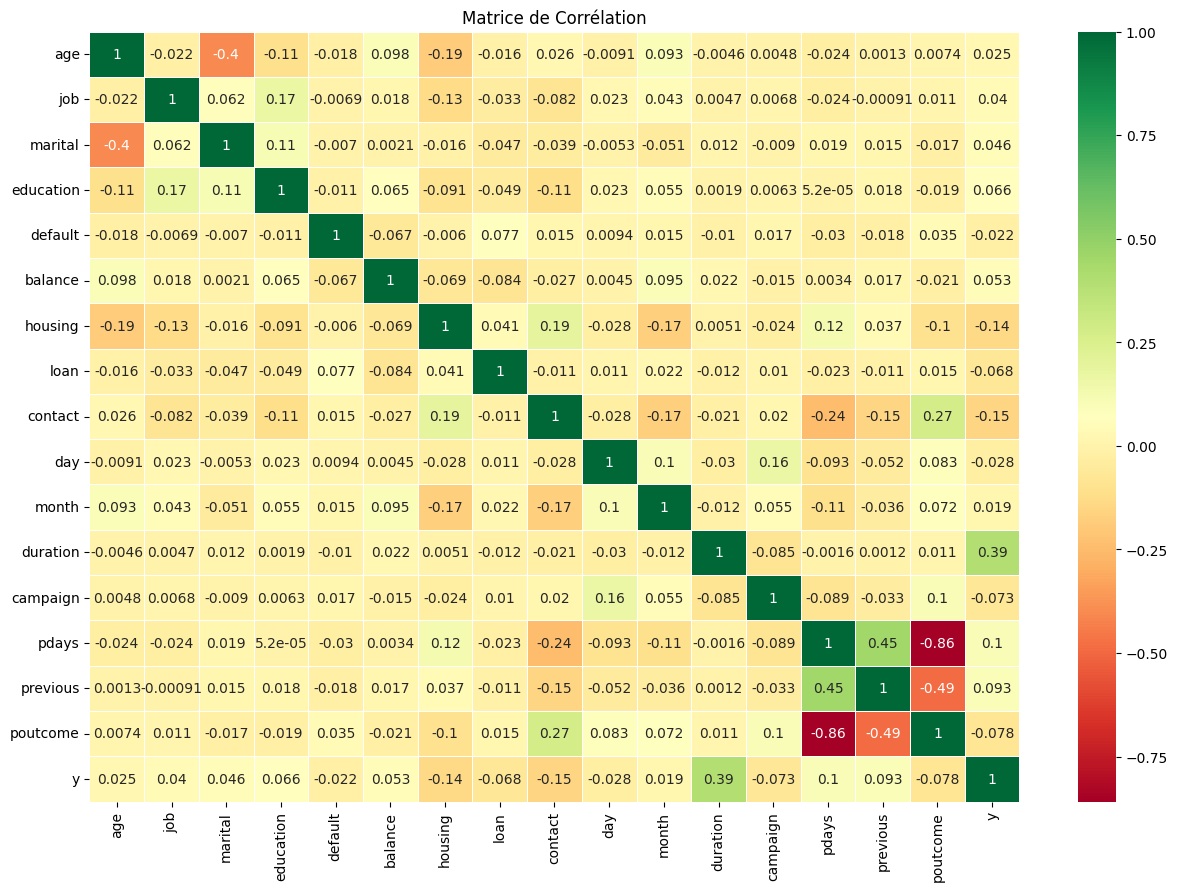

In [38]:
# affichage d'une matrice de corrélation
correlation_matrix = df_train_encoded.corr()

plt.figure(figsize=(15, 10))  # Définir la taille de la figure
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlGn', linewidths=0.5)
plt.title("Matrice de Corrélation")
plt.show()

On voit que la feature 'poutcome' est fortement corrélée avec 'pdays' et aussi, à une moindre mesure corrélée à la feature 'previous', on va donc supprimer cette colonne des dfs 'train' & 'test'.

In [40]:
# suppression de la colonne 'poutcome' dans les deux dfs
df_train_encoded.drop("poutcome", axis=1, inplace=True)
df_test_encoded.drop("poutcome", axis=1, inplace=True)

# affichage du df 'train' encodé après modification
df_train_encoded.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,y
0,58,4,1,2,0,2143,1,0,2,5,5,261,1,-1,0,0
1,44,9,2,1,0,29,1,0,2,5,5,151,1,-1,0,0
2,33,2,1,1,0,2,1,1,2,5,5,76,1,-1,0,0
3,47,1,1,3,0,1506,1,0,2,5,5,92,1,-1,0,0
4,33,11,2,3,0,1,0,0,2,5,5,198,1,-1,0,0
5,35,4,1,2,0,231,1,0,2,5,5,139,1,-1,0,0
6,28,4,2,2,0,447,1,1,2,5,5,217,1,-1,0,0
7,42,2,0,2,1,2,1,0,2,5,5,380,1,-1,0,0
8,58,5,1,0,0,121,1,0,2,5,5,50,1,-1,0,0
9,43,9,2,1,0,593,1,0,2,5,5,55,1,-1,0,0


In [41]:
# affichage des valeurs de la colonne 'pdays'
df_train_encoded["pdays"].value_counts()

pdays
-1      36954
 182      167
 92       147
 91       126
 183      126
        ...  
 449        1
 452        1
 648        1
 595        1
 530        1
Name: count, Length: 559, dtype: int64

On remarque qu'une majorité des clients ont pour valeur '-1' ce qui signifie qu'ils n'ont pas été recontacté suite à la campagne marketing et le reste des valeurs correspondent au nombre de fois où ils ont été contactés. Il est plus intéressant de transformer cette colonne en deux catégories : non-contacté, contacté

In [42]:
# fonction permettant la modification de la colonne 'pdays', 0 = client non-contacté & 1 = client contacté
def transform_pdays_column(df):
    df['pdays'] = df['pdays'].apply(lambda x: 0 if x == -1 else 1)
    return df

# application de la fonction aux dfs 'train' & 'test'
df_train_final = transform_pdays_column(df_train_encoded)
df_test_final = transform_pdays_column(df_test_encoded)

In [44]:
# affichage du df 'test' final
df_test_final.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,y
0,30,10,1,0,0,1787,0,0,0,19,10,79,1,0,0,0
1,33,7,1,1,0,4789,1,1,0,11,5,220,1,1,4,0
2,35,4,2,2,0,1350,1,0,0,16,4,185,1,1,1,0
3,30,4,1,2,0,1476,1,1,2,3,6,199,4,0,0,0
4,59,1,1,1,0,0,1,0,2,5,5,226,1,0,0,0
5,35,4,2,2,0,747,0,0,0,23,2,141,2,1,3,0
6,36,6,1,2,0,307,1,0,0,14,5,341,1,1,2,0
7,39,9,1,1,0,147,1,0,0,6,5,151,2,0,0,0
8,41,2,1,2,0,221,1,0,2,14,5,57,2,0,0,0
9,43,7,1,0,0,-88,1,1,0,17,4,313,1,1,2,0


## Machine Learning

### Régression logistique

In [72]:
# split du 'train' & 'test'
X_train_LogR = df_train_final.drop("y", axis=1)
y_train_LogR = df_train_final["y"]

X_test_LogR = df_test_final.drop("y", axis=1)
y_test_LogR = df_test_final["y"]

In [73]:
# standardisation des valeurs
scaler = StandardScaler()
X_train_LogR_scaled = scaler.fit_transform(X_train_LogR)
X_test_LogR_scaled = scaler.transform(X_test_LogR)

In [74]:
# création & entraînement du modèle
model_LogR = LogisticRegression()
model_LogR.fit(X_train_LogR_scaled, y_train_LogR)

LogisticRegression()

In [75]:
# enregistrement des prédictions
y_pred_LogR = model_LogR.predict(X_test_LogR_scaled)

Accuracy score with LogisticRegression: 89.05109489051095 %
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.98      0.94      4000
           1       0.57      0.21      0.30       521

    accuracy                           0.89      4521
   macro avg       0.74      0.59      0.62      4521
weighted avg       0.87      0.89      0.87      4521



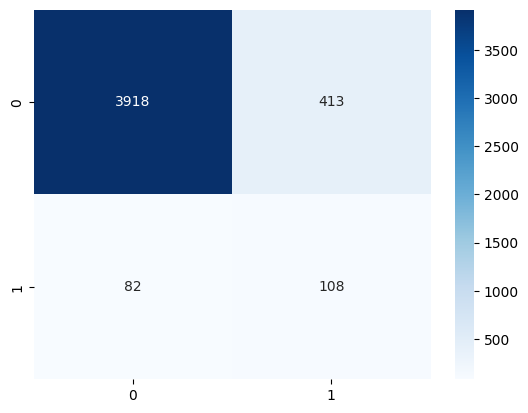

In [76]:
# affichage des résultats et d'une matrice de confusion
acc_logreg = accuracy_score(y_pred_LogR, y_test_LogR)
cm_logreg = confusion_matrix(y_pred_LogR, y_test_LogR)
class_report_LogR = classification_report(y_test_LogR, y_pred_LogR)
sns.heatmap(cm_logreg, annot=True, cmap='Blues', fmt='g')
print(f"Accuracy score with LogisticRegression:", acc_logreg*100,"%")
print("Classification Report:\n", class_report_LogR)

### XGBoost Classifier

In [77]:
# split du 'train' & 'test'
X_train_XGBC = df_train_final.drop("y", axis=1)
y_train_XGBC = df_train_final["y"]

X_test_XGBC = df_test_final.drop("y", axis=1)
y_test_XGBC = df_test_final["y"]

In [78]:
# standardisation des valeurs
scaler = StandardScaler()
X_train_XGBC_scaled = scaler.fit_transform(X_train_XGBC)
X_test_XGBC_scaled = scaler.transform(X_test_XGBC)

In [79]:
# création & entraînement du modèle
model_XGBC = xgb.XGBClassifier()
model_XGBC.fit(X_train_XGBC_scaled, y_train_XGBC)

c:\Users\utilisateur\Documents\GitHub\My-Credit\.credenv\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [80]:
# enregistrement des prédictions
y_pred_XGBC = model_XGBC.predict(X_test_XGBC_scaled)

In [83]:
X_test_XGBC_scaled

array([[-1.02990642,  1.72957334, -0.27576178, ..., -0.56935064,
        -0.47269435, -0.25194037],
       [-0.74738448,  0.81287683, -0.27576178, ..., -0.56935064,
         2.11553193,  1.48461123],
       [-0.55903653, -0.10381968,  1.3683719 , ..., -0.56935064,
         2.11553193,  0.18219753],
       ...,
       [ 1.51279098,  1.42400783, -0.27576178, ...,  2.65855226,
        -0.47269435, -0.25194037],
       [-1.21825437, -1.02051619, -0.27576178, ...,  0.39902023,
         2.11553193,  1.05047333],
       [ 0.28852927, -0.71495069,  1.3683719 , ..., -0.24656035,
         2.11553193,  2.78702493]])

Accuracy score with LogisticRegression: 94.58084494580845 %
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      4000
           1       0.80      0.71      0.75       521

    accuracy                           0.95      4521
   macro avg       0.88      0.84      0.86      4521
weighted avg       0.94      0.95      0.94      4521



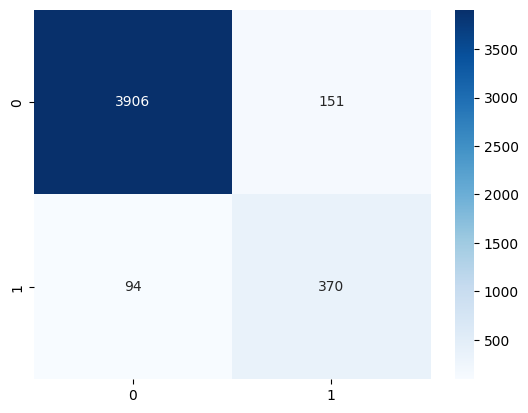

In [81]:
# affichage des résultats et d'une matrice de confusion
acc_xgbc = accuracy_score(y_pred_XGBC, y_test_XGBC)
cm_xgbc = confusion_matrix(y_pred_XGBC, y_test_XGBC)
class_report_XGBC = classification_report(y_test_XGBC, y_pred_XGBC)
sns.heatmap(cm_xgbc, annot=True, cmap='Blues', fmt='g')
print(f"Accuracy score with LogisticRegression:", acc_xgbc*100,"%")
print("Classification Report:\n", class_report_XGBC)